In [1]:
from dataclasses import dataclass
from typing import Any
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import src.game.game
import src.game.state
from src.game.game import Game
from src.game.state import GameState, GameStateTorch

import importlib
importlib.reload(src.game.game)
importlib.reload(src.game.state)
Game = src.game.game.Game
GameState = src.game.state.GameState
GameStateTorch = src.game.state.GameStateTorch

In [2]:
class RandomAgent:
    def __init__(self):
        pass

    def play(self, state: GameState) -> np.ndarray:
        return np.ones((8, 8), dtype=np.float32) / 64.0

class SmolQAgent(nn.Module):
    def __init__(self, epsilon: float = 0.1):
        super().__init__()
        self.epsilon = epsilon
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*8*8, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 64),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.head(x)
        return x

    def play(self, state: GameState) -> np.ndarray:
        state_torch = state.convert_to_torch()
        with torch.no_grad():
            res = self(state_torch.all_boards().unsqueeze(0)).squeeze(0)
            best_ind = torch.argmax(res)
            best_action_probs = torch.full_like(res, 0.0)
            best_action_probs.scatter_(0, best_ind.unsqueeze(0), 1.0)
            if self.training:
                if torch.rand(1).item() < self.epsilon:
                    best_action_probs = torch.ones_like(res) / res.numel()
        return best_action_probs.view(8, 8).cpu().numpy()


In [3]:
@dataclass
class ReplayEntry:
    state: GameStateTorch
    action: torch.Tensor # shape (1, ); index on flattened board (0-63 inclusive)
    reward: float
    next_state: GameStateTorch
    done: bool

In [4]:
def empty_game_state_torch() -> GameStateTorch:
    return GameStateTorch(
        blockers_board=torch.zeros((8, 8), dtype=torch.float32),
        selfq_board=torch.zeros((8, 8), dtype=torch.float32),
        oppq_board=torch.zeros((8, 8), dtype=torch.float32),
        legal_moves_mask=torch.ones((8, 8), dtype=torch.float32)
    )

In [25]:
def get_reward(game: Game, side: bool, legal: bool) -> float:
    reward = 0
    if game.result is not None:
        reward = 1 if game.result == side else -1
    # reward -= 0.04 if not legal else 0
    # reward += game.heuristic_reward()
    return reward * 10

In [ ]:
def train_step(agent: nn.Module, target: nn.Module, optimizer: torch.optim.Optimizer, buffer: list[ReplayEntry], GAMMA: float = 0.99) -> float:
    optimizer.zero_grad()
    device = buffer[0].state.selfq_board.device

    states = torch.stack([entry.state.all_boards() for entry in buffer]).to(device)
    actions = torch.stack([entry.action for entry in buffer]).to(device)
    rewards = torch.as_tensor([entry.reward for entry in buffer], dtype=torch.float32, device=device)
    next_states = torch.stack([entry.next_state.all_boards() for entry in buffer]).to(device)
    dones = torch.as_tensor([entry.done for entry in buffer], dtype=torch.float32, device=device)

    q_values = agent(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        best_actions = agent(next_states).argmax(1, keepdim=True)
        next_q_values = target(next_states).gather(1, best_actions).squeeze(1)
    target_q_values = rewards + (1 - dones) * next_q_values * GAMMA

    assert q_values.shape == target_q_values.shape, f"q_values shape {q_values.shape} does not match target_q_values shape {target_q_values.shape}"
    loss = nn.functional.mse_loss(q_values, target_q_values)
    loss.backward()
    optimizer.step()

    return loss.item()

In [27]:
def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            tau * source_param.data + (1.0 - tau) * target_param.data
        )

In [33]:
agent = SmolQAgent()
target = copy.deepcopy(agent)
oppo = RandomAgent()
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4, betas=(0.5, 0.999))
epoch = 0

In [34]:
buffer: list[ReplayEntry] = []
playing_or_training = True
ENTRIES_PER_TRAIN_STEP = 512
UPDATES_PER_TRAIN_STEP = 6
win_rate_graph = []
reward_graph = []
legal_graph = []

In [35]:
print(f"Epoch {epoch}")
while True:
# for _ in range(1):
    if playing_or_training:
        game = Game(agent, oppo)
        reward_list = []
        legal_list = []
        win_list = []
        for _ in range(ENTRIES_PER_TRAIN_STEP * 2):
            if game.result is not None:
                game.reset()
            if not game.is_white_turn:
                game.agent_move()
                if game.result is not None:
                    win_list.append(game.result)
                continue
            state = game.get_state().convert_to_torch()
            _, move, legal = game.agent_move()
            reward = get_reward(game, True, legal)
            reward_list.append(reward)
            legal_list.append(legal)
            if game.result is not None:
                win_list.append(game.result)
            done = game.result is not None
            next_state = game.get_state().convert_to_torch() if not done else empty_game_state_torch()
            entry = ReplayEntry(
                state=state,
                action=torch.tensor(move, dtype=torch.int64, device=state.selfq_board.device),
                reward=reward,
                next_state=next_state,
                done=done
            )
            buffer.append(entry)
            # if len(buffer) % 500 == 0:
            #     print(f"Buffer size: {len(buffer)}")
        playing_or_training = False
        reward_graph.append(np.mean(reward_list))
        legal_graph.append(len(list(x for x in legal_list if x)) / len(legal_list))
        win_rate_graph.append(len(list(x for x in win_list if x)) / len(win_list))
        print(f"Average reward: {np.mean(reward_list):.4f}, unnoised: {np.mean(reward_graph[-20:])}")
        print(f"Chance of legal move: {len(list(x for x in legal_list if x)) / len(legal_list):.2%}, unnoised: {np.mean(legal_graph[-20:]):.2%}")
        print(f"Win rate: {len(list(x for x in win_list if x)) / len(win_list):.2%}, unnoised: {np.mean(win_rate_graph[-20:]):.2%}")
        print(f"Games played this epoch: {len(win_list)}")
        print("Switching to training mode")
    else:
        agent.train()
        loss_list = []
        for i in range(UPDATES_PER_TRAIN_STEP):
            sample_buffer = random.sample(buffer, 64)
            loss = train_step(agent, target, optimizer, sample_buffer)
            loss_list.append(loss)
        print(f"Loss: mean={np.mean(loss_list):.4f}, median={np.median(loss_list):.4f}, std={np.std(loss_list):.4f}")
        random.shuffle(buffer)
        del buffer[:int(len(buffer) * 0.005)]
        soft_update(target, agent, tau=0.01)
        playing_or_training = True
        epoch += 1
        print()
        print(f"Epoch {epoch}")
        print("Switching to playing mode")


Epoch 0


/home/khang200923/proj/queen-duel-bot/src/game/game.py:106: RuntimeWarning: invalid value encountered in divide
  legal_action_probs /= legal_action_probs.sum()


Average reward: 0.3263, unnoised: 0.32629558541266795
Chance of legal move: 16.70%, unnoised: 16.70%
Win rate: 39.53%, unnoised: 39.53%
Games played this epoch: 43
Switching to training mode
Loss: mean=3.1211, median=3.1240, std=1.5619

Epoch 1
Switching to playing mode
Average reward: 0.4015, unnoised: 0.3639126110619745
Chance of legal move: 18.16%, unnoised: 17.43%
Win rate: 52.50%, unnoised: 46.02%
Games played this epoch: 40
Switching to training mode
Loss: mean=5.9380, median=6.1752, std=2.4424

Epoch 2
Switching to playing mode
Average reward: 0.4207, unnoised: 0.3828251059087478
Chance of legal move: 18.16%, unnoised: 17.68%
Win rate: 51.16%, unnoised: 47.73%
Games played this epoch: 43
Switching to training mode
Loss: mean=3.3342, median=3.8433, std=1.6343

Epoch 3
Switching to playing mode
Average reward: 0.4389, unnoised: 0.39685165385904175
Chance of legal move: 16.03%, unnoised: 17.26%
Win rate: 57.50%, unnoised: 50.17%
Games played this epoch: 40
Switching to training mod

KeyboardInterrupt: 

In [75]:
# base win rate
game = Game(oppo, oppo)
wins = 0
for _ in range(1000):
    game.reset()
    while game.result is None:
        game.agent_move()
    wins += 1 if game.result else 0
print(f"Base win rate: {wins / 1000:.2%}")

Base win rate: 48.40%


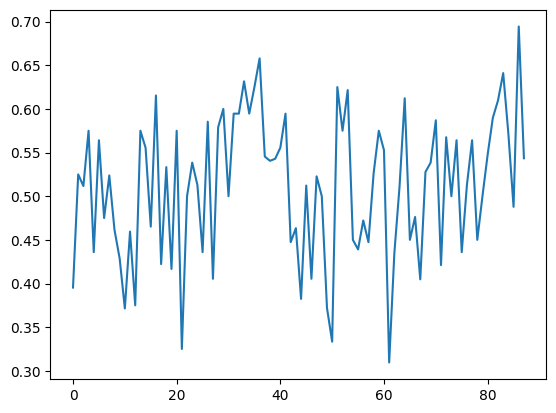

In [36]:
plt.plot(win_rate_graph)
plt.show()

In [118]:
graph_np = np.array(reward_graph)
autocorr = np.corrcoef(graph_np[:-1], graph_np[1:])[0, 1]
print(f"Autocorrelation: {autocorr:.4f}")

Autocorrelation: -0.0068


In [ ]:
def profiled():
    game = Game(oppo, oppo)
    wins = 0
    for _ in range(200):
        game.reset()
        while game.result is None:
            game.agent_move()
        wins += 1 if game.result else 0

%prun -s cumulative -l 10 profiled()

In [ ]:
# visual debug test
game = Game(agent, oppo)
game.reset()
while game.result is None:
    print(game.repr_board())
    print()
    game.agent_move()
print(game.repr_board())
print(f"result {game.result}")

In [ ]:
len(list(x for x in win_rate_graph if x > 0.5)) / len(win_rate_graph)

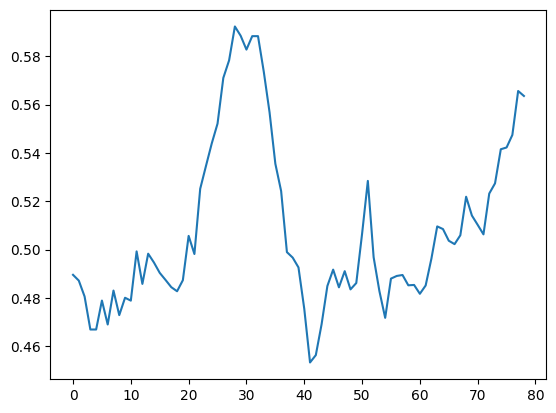

In [38]:
window = 10
smoothed = np.convolve(win_rate_graph, np.ones(window)/window, mode='valid')
plt.plot(smoothed)
plt.show()

In [22]:
game = Game(agent, oppo)
game.reset()
agent.forward(game.get_state().convert_to_torch().all_boards().unsqueeze(0)).squeeze(0).reshape((8, 8))

tensor([[-2.7077e-02,  2.4622e-02, -2.0043e-02,  2.2992e-02,  9.1224e-03,
          1.1036e-02, -2.4035e-02,  1.9179e-02],
        [-9.1947e-03,  2.4588e-02, -3.0065e-02, -9.8005e-04, -3.4669e-03,
         -1.3313e-02, -5.7244e-03, -2.3997e-03],
        [-1.2603e-03, -2.0736e-02, -2.7417e-03,  2.1418e-02,  4.4470e-03,
          2.3218e-03,  4.6612e-03, -7.4959e-03],
        [ 1.2510e-02,  5.4298e-03, -8.3117e-03,  1.4330e-03, -6.6165e-03,
          1.1530e-02, -9.8407e-03,  1.5042e-02],
        [-1.8386e-02,  9.3658e-03,  9.9359e-03, -1.9653e-02, -1.3068e-02,
         -7.8414e-04,  1.2098e-02, -1.6976e-02],
        [ 1.3452e-02, -1.4679e-02, -5.3522e-03, -1.5725e-02,  5.1055e-05,
         -5.1954e-03, -4.9041e-03, -1.8858e-02],
        [-3.6310e-04,  1.8811e-02,  1.8611e-02,  1.3951e-02, -7.0165e-03,
          1.0237e-03, -2.1091e-02,  6.9243e-03],
        [ 1.8076e-02,  2.2550e-03,  1.3703e-02, -1.5872e-02, -1.7862e-02,
         -7.1249e-03, -6.2182e-03,  8.8779e-04]], grad_fn=<ViewBa

In [ ]:
game.get_state().convert_to_torch().all_boards()